In [200]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display

# LeNet

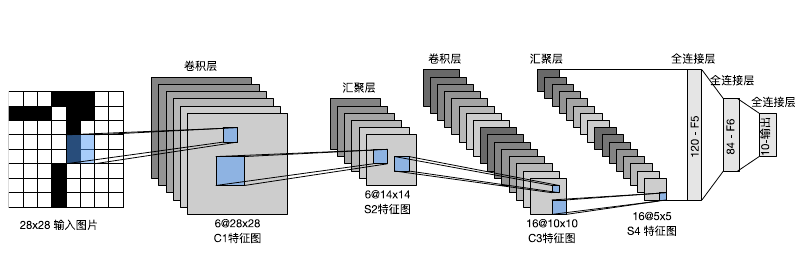

In [201]:
net = nn.Sequential(
  nn.Conv2d(1,6,kernel_size=5,padding=2), nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2,stride=2),
  nn.Conv2d(6,16,kernel_size=5), nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2,stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5 , 120), nn.Sigmoid(),
  nn.Linear(120 , 84), nn.Sigmoid(),
  nn.Linear(84,10)
)

In [202]:
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 模型训练

In [203]:

def load_data_fashion_mnist(batch_size, resize=None):
    """下载数据集并加载到内存中"""
    # 将图像从PIL类型转换为32位浮点数格式并/255，使得像素在0~1之间
    trans = [transforms.ToTensor()]
    if resize is not None:
        trans.insert(0,transforms.Resize((resize,resize)))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans,download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans,download=True
    )
    #内置的数据迭代器，shuffle打乱样本（训练数据使用）
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=4),
           data.DataLoader(mnist_test, batch_size, shuffle=False,
                           num_workers=4))

In [204]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [205]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [206]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [207]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  """GPU计算模型在数据集上的精度"""
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  # 正确预测的数量，总预测的数量
  metric = Accumulator(2)
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(X,list):
        #BERT微调所需的
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(accuracy(net(X),y),y.numel())
  return metric[0] / metric[1]

In [208]:
class MyAnimator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear',yscale='linear',
               fmts=('-','m--','g-','r:'),nrows=1,ncols=1,
               figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    

In [209]:
from dltool.plot import Animator

In [210]:
def train_CNN(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print("training on ",device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(),lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['train_loss','train_acc','test acc'])
  num_batches = len(train_iter)
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i, (X,y) in enumerate(train_iter):
      optimizer.zero_grad()
      X,y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l*X.shape[0],accuracy(y_hat,y),X.shape[0])
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch+1,(None, None,test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc: .3f}')
  print(f'{str(device)}')

In [211]:
from yangd2l.train import try_gpu

loss 0.471, train acc 0.825, test acc  0.811
cuda:0


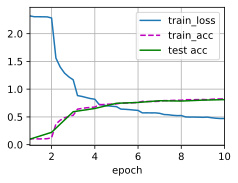

: 

In [212]:
lr,num_epochs = 0.9, 10
train_CNN(net, train_iter,test_iter, num_epochs,lr,try_gpu())